In [18]:
%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks
# pip install -e .

Found GPU at: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse, copy

from model import *
from utils import *
from measures import *

In [20]:
seed = 12345
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Hyperparamters
batch_size = 64 
epochs = 22
lrs = [3e-1, 3e-2, 3e-3, 3e-4, 3e-5, 3e-6]  
gamma = 0.7
momentum = 0.9


use_cuda = torch.cuda.is_available()
# train_loader, test_loader = dataloaders(batch_size, use_cuda, seed)
train_loader, val_loader, test_loader = dataloaders(batch_size, use_cuda, seed)
print (len(train_loader.dataset), len(val_loader), len(test_loader.dataset))

model = Net().to(device)
# num_val_examples = 12000
#(below 188 is number of batches in val set. (188*32 - validation samples))

60000 188 10000


In [0]:
# Grid Search over different learning rates - over validation dataset
val_losses = []
for lr in lrs:
    print ("lr:", lr)
    model_copy = copy.deepcopy(model)
    optimizer = optim.RMSprop(model_copy.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train_loss = train_sel_lr(model_copy, device, train_loader, optimizer, epoch, batch_size)
        val_loss = test(model_copy, device, val_loader, batch_size)
        # test_loss = test(model_copy, device, test_loader, batch_size)  # one can see on test_loss as well.....
        scheduler.step()
    val_losses.append(val_loss)
print ("Validation Losses::\n", val_losses)        


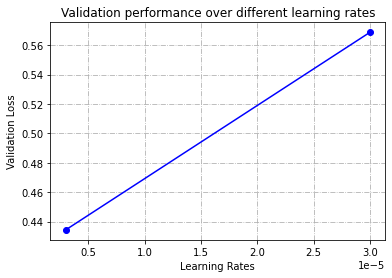

In [17]:
fig = plt.figure()
plt.plot(lrs[4:6], val_losses[4:6], color='blue', marker='o') ####
plt.xlabel('Learning Rates')
plt.ylabel('Validation Loss')
plt.title("Validation performance over different learning rates")
plt.grid(True, linestyle='-.')
fig.show()   
# plt.legend(['3e-1', '3e-2', '3e-3', '3e-4', '3e-5', '3e-6'], loc='upper right')
"""best lr = 3e-6 in case of RMSprop"""


Test set: Average loss: 0.5190, Accuracy: 8165/10000 (82%)


Test set: Average loss: 0.4712, Accuracy: 8290/10000 (83%)


Test set: Average loss: 0.4485, Accuracy: 8343/10000 (83%)


Test set: Average loss: 0.4333, Accuracy: 8390/10000 (84%)


Test set: Average loss: 0.4233, Accuracy: 8403/10000 (84%)


Test set: Average loss: 0.4220, Accuracy: 8423/10000 (84%)


Test set: Average loss: 0.4169, Accuracy: 8428/10000 (84%)


Test set: Average loss: 0.4140, Accuracy: 8430/10000 (84%)


Test set: Average loss: 0.4110, Accuracy: 8434/10000 (84%)


Test set: Average loss: 0.4115, Accuracy: 8439/10000 (84%)


Test set: Average loss: 0.4122, Accuracy: 8446/10000 (84%)


Test set: Average loss: 0.4086, Accuracy: 8446/10000 (84%)


Test set: Average loss: 0.4103, Accuracy: 8448/10000 (84%)


Test set: Average loss: 0.4074, Accuracy: 8446/10000 (84%)


Test set: Average loss: 0.4076, Accuracy: 8451/10000 (85%)


Test set: Average loss: 0.4080, Accuracy: 8450/10000 (84%)


Test set: Average loss:

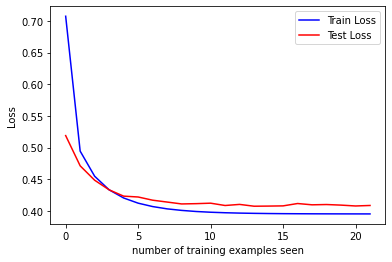

In [21]:
train_losses, test_losses = [], []
train_size = len(train_loader.dataset)
lr = 3e-6 # good one - lowest validation loss among others
sigmas = [0.001,0.003,0.006,0.009,0.03,0.06,0.09]    
delta = 1e-2
mean = 0.0

weight_norms_list = []
sharpness_list = []
var_gradients_list = []  


optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    train_loss, grad_norms, grad_avg = train(model, device, train_loader, optimizer, epoch, batch_size)
    train_losses.append(train_loss)
    test_loss = test(model, device, test_loader, batch_size)
    test_losses.append(test_loss)
    scheduler.step()
    
    # computing var_score over one epoch
    variance_score = compute_grad_variance(grad_norms, grad_avg)
    # print ("var score", variance_score)
    var_gradients_list.append(variance_score)
    
show_losses(train_losses, test_losses)

In [23]:
# print train and test losses and their difference
diff_test_train = np.array(test_losses)  - np.array(train_losses)
print ("diff_test_train::\n", diff_test_train)

diff_test_train::
 [-1.88496086e-01 -2.32279445e-02 -6.29029481e-03  1.72907110e-05
  2.90073858e-03  9.74287581e-03  1.00553006e-02  1.07529502e-02
  1.01943847e-02  1.23704007e-02  1.42918368e-02  1.14406469e-02
  1.37321824e-02  1.12742112e-02  1.17640907e-02  1.22880763e-02
  1.61465102e-02  1.42042337e-02  1.47196371e-02  1.38405302e-02
  1.25209108e-02  1.33365116e-02]


var_gradients:
 [tensor(1.7399), tensor(1.6165), tensor(1.5270), tensor(1.4534), tensor(1.4161), tensor(1.3880), tensor(1.3891), tensor(1.3683), tensor(1.3532), tensor(1.3455), tensor(1.3443), tensor(1.3471), tensor(1.3417), tensor(1.3441), tensor(1.3269), tensor(1.3316), tensor(1.3404), tensor(1.3426), tensor(1.3437), tensor(1.3290), tensor(1.3297), tensor(1.3315)]


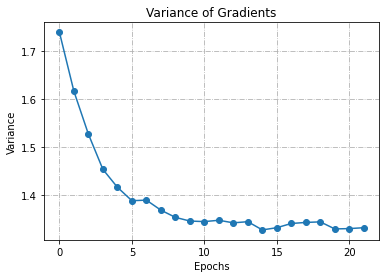

In [26]:
print ("var_gradients:\n", var_gradients_list)
import numpy as np
plt.plot(np.arange(epochs), var_gradients_list, marker='o')
plt.grid(True, linestyle='-.')
# plt.legend() #loc='lower left'
plt.title("Variance of Gradients")
plt.ylabel("Variance")
plt.xlabel("Epochs")
plt.show()	  

In [27]:
"""run for each sigma"""
std_list = []
mean_list = []

for sigma in sigmas:
    weight_l2_norm = cal_l2_norm(model)
    weight_bound = compute_bound(model, train_size, sigma, weight_l2_norm, delta)  
    weight_norms_list.append(weight_bound)
    # print ("norm bound:::", weight_bound)

    #to calculate sharpness, perturb the same model 10 times, then get expected value
    num_times = 10
    p_train_losses = []
    for iterate in range(num_times):
        p_model = copy.deepcopy(model)
        p_model = weight_pertubation(p_model, mean, sigma, device)
        p_train_loss = test(p_model, device, train_loader, batch_size)
        p_train_losses.append(p_train_loss)
    exp_p_error = sum(p_train_losses) / len(p_train_losses)
    std_list.append(np.std(np.array(p_train_losses)))
    mean_list.append(np.mean(np.array(p_train_losses)))

    sharpness = exp_p_error - train_loss
    # print ("sharpness:::", sharpness)
    sharpness_list.append(sharpness)

# accuracy will be 85%...not 68%    ;;;;; scaling difference - 


Test set: Average loss: 0.3954, Accuracy: 40924/60000 (68%)


Test set: Average loss: 0.3955, Accuracy: 40924/60000 (68%)


Test set: Average loss: 0.3955, Accuracy: 40915/60000 (68%)


Test set: Average loss: 0.3955, Accuracy: 40921/60000 (68%)


Test set: Average loss: 0.3954, Accuracy: 40924/60000 (68%)


Test set: Average loss: 0.3954, Accuracy: 40921/60000 (68%)


Test set: Average loss: 0.3956, Accuracy: 40917/60000 (68%)


Test set: Average loss: 0.3956, Accuracy: 40915/60000 (68%)


Test set: Average loss: 0.3954, Accuracy: 40929/60000 (68%)


Test set: Average loss: 0.3955, Accuracy: 40920/60000 (68%)


Test set: Average loss: 0.3969, Accuracy: 40908/60000 (68%)


Test set: Average loss: 0.3972, Accuracy: 40915/60000 (68%)


Test set: Average loss: 0.3971, Accuracy: 40880/60000 (68%)


Test set: Average loss: 0.3975, Accuracy: 40889/60000 (68%)


Test set: Average loss: 0.3970, Accuracy: 40891/60000 (68%)


Test set: Average loss: 0.3974, Accuracy: 40889/60000 (68%)


Test se

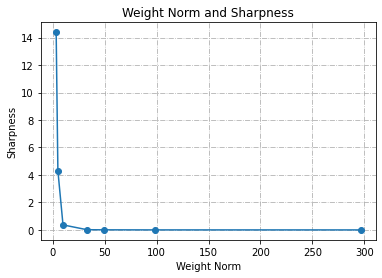

In [28]:
plt.plot(weight_norms_list, sharpness_list, marker='o')
plt.grid(True, linestyle='-.')
plt.title("Weight Norm and Sharpness")
plt.xlabel("Weight Norm")
plt.ylabel("Sharpness")
plt.show()
# plt.legend() #loc='lower left'

In [30]:
print ("sharpness_list::\n", sharpness_list)
print ("weight_norms_list::\n", weight_norms_list)
print ("std_list::\n", std_list)
print ("mean_list::\n", mean_list)	        

shapness_list::
 [0.00019908276398977742, 0.0018572524180015537, 0.007035553237795866, 0.016088750778635363, 0.36574550720254584, 4.315006888868411, 14.386127941530944]
weight_norms_list::
 [296.3475036621094, 98.78251647949219, 49.39128875732422, 32.92756271362305, 9.878469467163086, 4.9395647048950195, 3.293409585952759]
std_list::
 [7.378508160410768e-05, 0.0002504745314904585, 0.001314003169631389, 0.002761420795303824, 0.17335362772867605, 1.5995280259981999, 3.00920131988729]
mean_list::
 [0.39546136365532875, 0.3971195333093405, 0.40229783412913483, 0.41135103166997433, 0.7610077880938848, 4.7102691697597505, 14.781390222422283]
